# LangGraphで作るAIエージェント実践入門

## 9.3 ハンズオン：Q&Aアプリケーション

In [1]:
!pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 pydantic==2.10.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6

In [1]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [2]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

In [3]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(
        default="", description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="回答履歴"
    )
    current_judge: bool = Field(
        default=False, description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="", description="品質チェックの判定理由"
    )

In [16]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

# モデル変更4o→
llm = ChatOpenAI(model="gpt-5-nano", temperature=1)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_completion_tokens'))

In [17]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
"""質問を分析し、最も適切な回答担当ロールを選択してください。

選択肢:
{role_options}

回答は選択肢の番号（1、2、または3）のみを返してください。

質問: {query}
""".strip()
    )
    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}

In [18]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
"""あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

In [19]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="判定結果")
    reason: str = Field(default="", description="判定理由")

def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
"""以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
また、その判断理由も説明してください。

ユーザーからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
    }

In [20]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [21]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [22]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

In [23]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

In [24]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

In [25]:
compiled = workflow.compile()

In [26]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

In [27]:
result

{'query': '生成AIについて教えてください',
 'current_role': '一般知識エキスパート',
 'messages': ['生成AIは、データから新しいコンテンツを自動的に作り出す人工知能の総称です。テキスト、画像、音声、動画、コードなど、さまざまな形式の「新規作成」を高速かつ高品質に行える技術のことを指します。近年は大規模言語モデル（LLM）や拡散モデル、音声モデルなどが組み合わさって、実用性と創造性の両方を高めています。\n\n以下、一般知識としての要点と、生成AI製品を使う際の実践的な視点を整理します。\n\n1) 生成AIの仕組みと代表的な技術\n- コアとなるモデル\n  - 大規模言語モデル（LLM）: 文を連続的に生成する autoregressive な仕組み。例: テキスト生成、要約、翻訳、質問応答など。\n  - 拡散モデル: ノイズを徐々に除去して高品質な画像や音声を生成。画像生成で特に普及。\n  - 自動符号化/生成系: VAE（Variational Autoencoder）型や組み合わせモデルも利用される。\n- 学習の基本\n  - 自己教師付き学習（self-supervised）で大量のデータから「次に来る語を予測する」「ノイズを元に戻す」などのタスクを学習。\n  - 指示に従う能力を高めるための「インストラクションチューニング」や、実世界のタスク適応のための「RLHF（Reinforcement Learning from Human Feedback）」などを用いることが多い。\n- Prompt（プロンプト）と出力の制御\n  - プロンプト設計（prompt engineering）により、出力の形式、長さ、トーン、信頼性をある程度操作可能。\n  - 温度設定、トップ-p、ビーム探索などのパラメータで創造性と信頼性のバランスを調整。\n\n2) 学習データと倫理・法的な留意点\n- 学習データの出典と権利\n  - 大規模データセットにはウェブ上の公開テキスト、書籍、コード、画像などが含まれることが多く、著作権やデータプライバシー、データ出典の適法性が重要な議論点です。\n- 出力の信頼性とリスク\n  - 「ハルシネーション」（事実と異なる情報の生成）、偏見、プライバシー侵害のリスクがありま

In [28]:
print(result["messages"][-1])

生成AIは、データから新しいコンテンツを自動的に作り出す人工知能の総称です。テキスト、画像、音声、動画、コードなど、さまざまな形式の「新規作成」を高速かつ高品質に行える技術のことを指します。近年は大規模言語モデル（LLM）や拡散モデル、音声モデルなどが組み合わさって、実用性と創造性の両方を高めています。

以下、一般知識としての要点と、生成AI製品を使う際の実践的な視点を整理します。

1) 生成AIの仕組みと代表的な技術
- コアとなるモデル
  - 大規模言語モデル（LLM）: 文を連続的に生成する autoregressive な仕組み。例: テキスト生成、要約、翻訳、質問応答など。
  - 拡散モデル: ノイズを徐々に除去して高品質な画像や音声を生成。画像生成で特に普及。
  - 自動符号化/生成系: VAE（Variational Autoencoder）型や組み合わせモデルも利用される。
- 学習の基本
  - 自己教師付き学習（self-supervised）で大量のデータから「次に来る語を予測する」「ノイズを元に戻す」などのタスクを学習。
  - 指示に従う能力を高めるための「インストラクションチューニング」や、実世界のタスク適応のための「RLHF（Reinforcement Learning from Human Feedback）」などを用いることが多い。
- Prompt（プロンプト）と出力の制御
  - プロンプト設計（prompt engineering）により、出力の形式、長さ、トーン、信頼性をある程度操作可能。
  - 温度設定、トップ-p、ビーム探索などのパラメータで創造性と信頼性のバランスを調整。

2) 学習データと倫理・法的な留意点
- 学習データの出典と権利
  - 大規模データセットにはウェブ上の公開テキスト、書籍、コード、画像などが含まれることが多く、著作権やデータプライバシー、データ出典の適法性が重要な議論点です。
- 出力の信頼性とリスク
  - 「ハルシネーション」（事実と異なる情報の生成）、偏見、プライバシー侵害のリスクがあります。
- 著作権・利用権
  - 生成物の著作権の扱い、訓練データに基づく盗用の懸念など、分野ごとに法的な解釈が変わる場合があります。

3) 主な用途と具体例
- テキスト系
  - 記事

In [29]:
initial_state = State(query="生成AIについて教えてください")
result = await compiled.ainvoke(initial_state)
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['以下は、生成AI（Generative AI）について、生成AI製品エキスパートの視点からの解説と実務的なガイドです。必要に応じて、あなたの状況に合わせて深掘りします。\n\n1) 生成AIとは何か\n- 定義: 大量のデータを元に、自然言語・画像・音声・コードなどの新しいデータを自動で生成するAI技術の総称。主に事前学習済みの大規模モデルを用いて、指示（プロンプト）に応じた出力を作り出します。\n- 主な分野と出力形態:\n  - テキスト生成: 記事要約、会話、翻訳、創作など\n  - 画像生成・編集: イラスト、写真風画像の生成、スタイル変換\n  - コード生成: 自動補完・新規コード作成・デバッグ支援\n  - 音声・動画生成: 音声合成、動画の生成・編集\n  - マルチモーダル: テキストと画像を組み合わせた出力、画像説明生成など\n- 典型的な技術要素: トランスフォーマーモデル、拡散モデル、強化学習由来の制御（例: RLHF、RLAIF）、Retriever-augmented generation（RAG）など。\n\n2) 基本的な技術と設計のポイント\n- モデルの種類と用途\n  - LLM（大規模言語モデル）: テキスト中心の生成・理解\n  - Diffusion系モデル: 高品質な画像生成\n  - コードモデル: プログラミング支援\n  - マルチモーダルモデル: 複数のデータ形態を統合\n- 学習と適応\n  - 事前学習（pretraining）と微調整（finetuning）、指示適合（instruction tuning）や安全性のための強化学習（RLHF/RLAIF）\n  - Retrievalベースのアプローチ: 外部知識を取り込み、事実性を高める\n- 出力の性質\n  - ハルチュネーション（誤情報生成）のリスク\n  - バイアス、差別、著作権・倫理問題の潜在性\n  - セーフティとコンテンツポリシーの重要性\n\n3) 生成AIを製品化する際の実務ガイド\n- ユースケース設計\n  - 明確なペルソナとタスク定義、成功指標を最初に決める\n  - 現場の

In [30]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 35 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

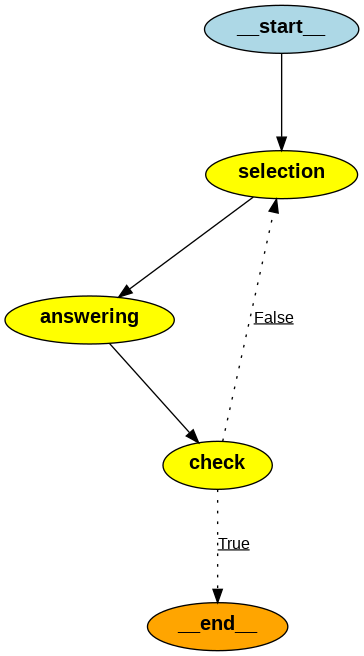

In [31]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

## 9.4 チェックポイント機能：ステートの永続化と再会

In [32]:
!pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 langgraph-checkpoint==1.0.11

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 1.0.12
    Uninstalling langgraph-checkpoint-1.0.12:
      Successfully uninstalled langgraph-checkpoint-1.0.12


In [1]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [3]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-5-nano-2025-08-07", temperature=1)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

In [4]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)

In [5]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

In [6]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅が好きなのですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 47, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--e475bd46-b490-483e-8f62-f2f2ebb60de8-0', usage_metadata={'input_tokens': 47, 'output_tokens': 342, 'total_tokens': 389})]}

In [7]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f07b374-29a5-690a-8002-df355abe453d'}}, checkpoint={'v': 1, 'ts': '2025-08-17T06:56:11.931447+00:00', 'id': '1f07b374-29a5-690a-8002-df355abe453d', 'channel_values': {'query': '私の好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。ずんだ餅が好きなのですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 47, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logpro

In [8]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅が好きなのですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 47, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--e475bd46-b490-483e-8f62-f2f2ebb60de8-0', usage_metadata={'input_tokens': 47, 'output_tokens': 342, 'total_tokens': 389})],
               

In [9]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅が好きなのですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 47, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--e475bd46-b490-483e-8f62-f2f2ebb60de8-0', usage_metadata={'input_tokens': 47, 'output_tokens': 342, 'total_tokens': 389}),
  HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、ずんだ餅が好きなのを覚えています。', addition

In [10]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f07b379-6691-6df1-8006-f3f994f6e0e0'}}, checkpoint={'v': 1, 'ts': '2025-08-17T06:58:32.537423+00:00', 'id': '1f07b379-6691-6df1-8006-f3f994f6e0e0', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。ずんだ餅が好きなのですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 47, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None},

In [11]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅が好きなのですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 47, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--e475bd46-b490-483e-8f62-f2f2ebb60de8-0', usage_metadata={'input_tokens': 47, 'output_tokens': 342, 'total_tokens': 389}),
                

In [12]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='分かりません。あなたの好物を教えてください。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 471, 'prompt_tokens': 35, 'total_tokens': 506, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--e315ace9-a18d-4d20-809b-f88dff5c8cfa-0', usage_metadata={'input_tokens': 35, 'output_tokens': 471, 'total_tokens': 506})]}